[View in Colaboratory](https://colab.research.google.com/github/fabiansd/AI-workshop/blob/master/House_price_prediction_showcase.ipynb)

In [35]:
## Import av biblioteker og settings
import sklearn
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#############################################################################


## Laster ned datasettet fra lenken og lagrer dette som filen Melbourne_train.csv
from six.moves import urllib
urllib.request.urlretrieve("https://raw.githubusercontent.com/fabiansd/AI-workshop/master/data/Melbourne_train.csv", "./Melbourne_train.csv")
data = pd.read_csv('Melbourne_train.csv')

# Velger kolonnene man ønsker i det nye datasettet
aktuelle_kolonner = ['Id','LotArea','Neighborhood','WoodDeckSF','Condition1','HouseStyle','OverallQual','OverallCond','YearBuilt','YearRemodAdd','1stFlrSF','FullBath','HalfBath','BedroomAbvGr','Fence','KitchenAbvGr','TotRmsAbvGrd','GarageCars','GarageArea','Fireplaces','PoolArea','PoolQC','MoSold','YrSold']
data_modell = data[aktuelle_kolonner]

# Eksempel på generering av ny kolonne
data_modell['HouseAge'] = data['YrSold'] - data['YearBuilt']

#Fence NaN endret til None
data_modell['Fence'] = data_modell['Fence'].fillna('None')

#Salgspris legges til på slutten
data_modell['SalePrice'] = data['SalePrice']

#Ekstrempunkter mht kvadratfot fjernet
data_modell = data_modell[data['LotArea'] < 100000]

#Skriver ut de 5 første radene
data_modell.head(15)

,Id,LotArea,Neighborhood,WoodDeckSF,Condition1,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,FullBath,HalfBath,BedroomAbvGr,Fence,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,Fireplaces,PoolArea,PoolQC,MoSold,YrSold,HouseAge,SalePrice
0,1,8450,CollgCr,0,Norm,2Story,7,5,2003,2003,856,2,1,3,None,1,8,2,548,0,0,NaN,2,2008,5,208500
1,2,9600,Veenker,298,Feedr,1Story,6,8,1976,1976,1262,2,0,3,None,1,6,2,460,1,0,NaN,5,2007,31,181500
2,3,11250,CollgCr,0,Norm,2Story,7,5,2001,2002,920,2,1,3,None,1,6,2,608,1,0,NaN,9,2008,7,223500
3,4,9550,Crawfor,0,Norm,2Story,7,5,1915,1970,961,1,0,3,None,1,7,3,642,1,0,NaN,2,2006,91,140000
4,5,14260,NoRidge,192,Norm,2Story,8,5,2000,2000,1145,2,1,4,None,1,9,3,836,1,0,NaN,12,2008,8,250000
5,6,14115,Mitchel,40,Norm,1.5Fin,5,5,1993,1995,796,1,1,1,MnPrv,1,5,2,480,0,0,NaN,10,2009,16,143000
6,7,10084,Somerst,255,Norm,1Story,8,5,2004,2005,1694,2,0,3,None,1,7,2,636,1,0,NaN,8,2007,3,307000
7,8,10382,NWAmes,235,PosN,2Story,7,6,1973,1973,1107,2,1,3,None,1,7,2,484,2,0,NaN,11,2009,36,200000
8,9,6120,OldTown,90,Artery,1.5Fin,7,5,1931,1950,1022,2,0,2,None,2,8,2,468,2,0,NaN,4,2008,77,129900
9,10,7420,BrkSide,0,Artery,1.5Unf,5,6,1939,1950,1077,1,0,2,None,2,5,1,205,2,0,NaN,1,2008,69,118000


#NaN

In [36]:
data_modell[['PoolArea','PoolQC']].head()

,PoolArea,PoolQC
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN


In [37]:
data_modell[['PoolArea','PoolQC']][data_modell['PoolArea'] > 0].head()

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd


In [38]:
data_modell['PoolQC'] = data_modell['PoolQC'].fillna(value='None')
data_modell[['PoolArea','PoolQC']].head()

,PoolArea,PoolQC
0,0,None
1,0,None
2,0,None
3,0,None
4,0,None


#Unyttige attributter

In [39]:
data_modell['Fence'].value_counts()

None     1175
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

#Algoritmer foretrekker tall

In [40]:


## Oppretter encodere for de ulike kategoriene vi ønsker å transformere fra tekst til tall.
Neighborhood_enc = preprocessing.LabelEncoder()
Condition1_enc = preprocessing.LabelEncoder()
HouseStyle_enc = preprocessing.LabelEncoder()
Fence_enc = preprocessing.LabelEncoder()
PoolQualityCondition_enc = preprocessing.LabelEncoder()

## Konverterer kolonnene som inneholder tekstverdier til tallverdier
data_modell['Neighborhood'] = Neighborhood_enc.fit_transform(data_modell['Neighborhood'])
data_modell['Condition1'] = Condition1_enc.fit_transform(data_modell['Condition1'])
data_modell['HouseStyle'] = HouseStyle_enc.fit_transform(data_modell['HouseStyle'])
data_modell['Fence'] = Fence_enc.fit_transform(data_modell['Fence'])
data_modell['PoolQC'] = PoolQualityCondition_enc.fit_transform(data_modell['PoolQC'])

#Skriver ut de 5 første radene
data_modell.head(10)

,Id,LotArea,Neighborhood,WoodDeckSF,Condition1,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,FullBath,HalfBath,BedroomAbvGr,Fence,KitchenAbvGr,TotRmsAbvGrd,GarageCars,GarageArea,Fireplaces,PoolArea,PoolQC,MoSold,YrSold,HouseAge,SalePrice
0,1,8450,5,0,2,5,7,5,2003,2003,856,2,1,3,4,1,8,2,548,0,0,3,2,2008,5,208500
1,2,9600,24,298,1,2,6,8,1976,1976,1262,2,0,3,4,1,6,2,460,1,0,3,5,2007,31,181500
2,3,11250,5,0,2,5,7,5,2001,2002,920,2,1,3,4,1,6,2,608,1,0,3,9,2008,7,223500
3,4,9550,6,0,2,5,7,5,1915,1970,961,1,0,3,4,1,7,3,642,1,0,3,2,2006,91,140000
4,5,14260,15,192,2,5,8,5,2000,2000,1145,2,1,4,4,1,9,3,836,1,0,3,12,2008,8,250000
5,6,14115,11,40,2,0,5,5,1993,1995,796,1,1,1,2,1,5,2,480,0,0,3,10,2009,16,143000
6,7,10084,21,255,2,2,8,5,2004,2005,1694,2,0,3,4,1,7,2,636,1,0,3,8,2007,3,307000
7,8,10382,14,235,4,5,7,6,1973,1973,1107,2,1,3,4,1,7,2,484,2,0,3,11,2009,36,200000
8,9,6120,17,90,0,0,7,5,1931,1950,1022,2,0,2,4,2,8,2,468,2,0,3,4,2008,77,129900
9,10,7420,3,0,0,1,5,6,1939,1950,1077,1,0,2,4,2,5,1,205,2,0,3,1,2008,69,118000


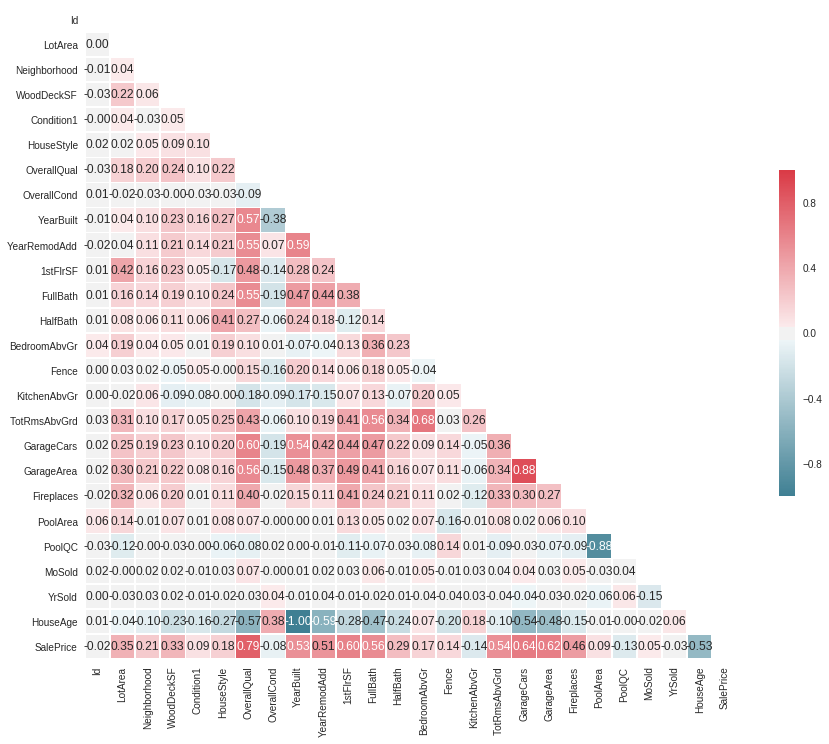

In [41]:
sns.set(style="white")


# Compute the correlation matrix
corr = data_modell.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot = True,fmt = ".2f", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [42]:

# Vi dropper unyttige attributter
data_modell_desilled = data_modell.drop(['Id','OverallCond','BedroomAbvGr','KitchenAbvGr','GarageArea','PoolArea','MoSold','YrSold'], axis=1)


## Sjekker at kolonnene med kategoriske features har fått tallverdier
data_modell_desilled.head(5)

,LotArea,Neighborhood,WoodDeckSF,Condition1,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,1stFlrSF,FullBath,HalfBath,Fence,TotRmsAbvGrd,GarageCars,Fireplaces,PoolQC,HouseAge,SalePrice
0,8450,5,0,2,5,7,2003,2003,856,2,1,4,8,2,0,3,5,208500
1,9600,24,298,1,2,6,1976,1976,1262,2,0,4,6,2,1,3,31,181500
2,11250,5,0,2,5,7,2001,2002,920,2,1,4,6,2,1,3,7,223500
3,9550,6,0,2,5,7,1915,1970,961,1,0,4,7,3,1,3,91,140000
4,14260,15,192,2,5,8,2000,2000,1145,2,1,4,9,3,1,3,8,250000


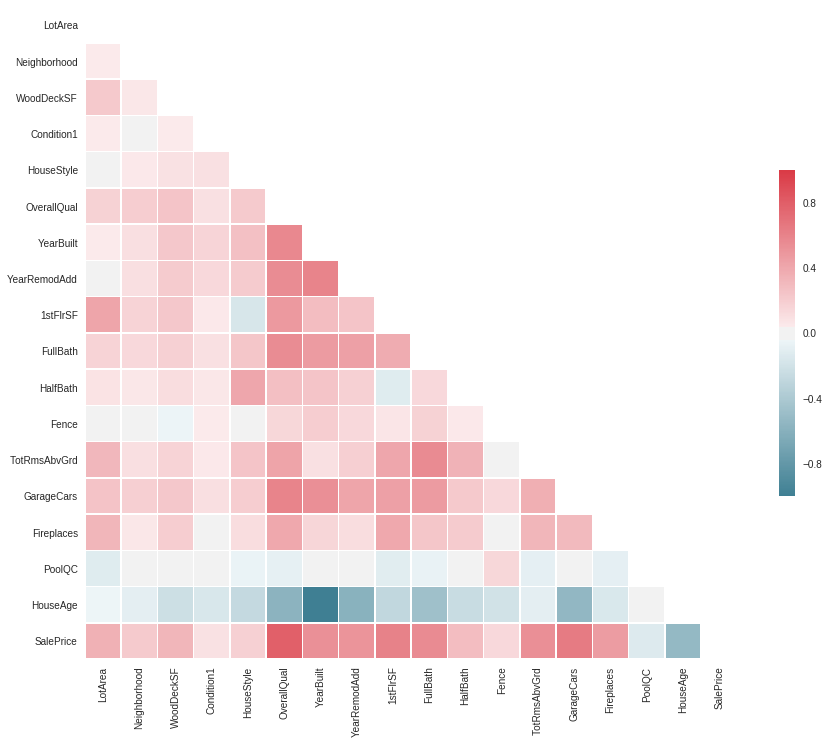

In [43]:
sns.set(style="white")


# Compute the correlation matrix
corr = data_modell_desilled.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#Regresjonsmodeller

##Oppdeling av data

In [46]:
from sklearn.model_selection import train_test_split

#Velg alle kolonner untatt den siste. Denne inneholder Salgsprisen som vi ønsker å predikere
input_data = data_modell_desilled.iloc[:,0:-1].copy(deep=True)

#Velg kun siste kolonne. Dette er salgsprisen
output_data = data_modell_desilled['SalePrice'].copy(deep=True)

#Dataen deles opp i to sett: treningssett og testsett og lagres i de 4 nye objektene. Test_size bestemmer andelen av dataen som blir brukt til testing av modellen
input_treningsdata, input_testdata, output_treningsdata, output_testdata = train_test_split(input_data, output_data, test_size=0.2, random_state=1)

print('Input_treningsdata: {}, input_testdata: {}, output_treningsdata: {} og output_testdata: {}'.format(input_treningsdata.shape, input_testdata.shape, output_treningsdata.shape, output_testdata.shape))

## Importerer metode for å måle gjennomsnittlig absolutt feil
from sklearn.metrics import mean_absolute_error

Input_treningsdata: (1164, 17), input_testdata: (292, 17), output_treningsdata: (1164,) og output_testdata: (292,)


## Lineær regresjon

In [67]:
#Treningsfase
from sklearn.linear_model import LinearRegression

#Regressjons-objekt fra scikit-learn
modell = LinearRegression()

#Tilpass regressjonskoeffesienter med treningsdata
modell.fit(input_treningsdata, output_treningsdata)

#Testfase

#Gjør pris-prediksjon på testdataen. 
pris_prediksjone_linr = modell.predict(input_testdata)

#Beregn feil
MAE_lin = mean_absolute_error(pris_prediksjone_linr, output_testdata)

#Feilen skrives ut
print("MAE: {}".format(MAE_lin))

MAE: 26641.9329536


## Lineær "Support Vector Regression" (SVR)

In [50]:
#Treningsfase
from sklearn.svm import SVR

#Regressjons-objekt fra scikit-learn
modell = SVR(kernel='linear')

#Tilpass regressjonskoeffesienter med treningsdata
modell.fit(input_treningsdata, output_treningsdata)

#Testfase

#Gjør pris-prediksjon på testdataen. 
pris_prediksjoner_SVR = modell.predict(input_testdata)

#Beregn feil
MAE_SVR = mean_absolute_error(pris_prediksjoner_SVR, output_testdata)

#Feilen skrives ut
print("MAE: {}".format(MAE_SVR))

MAE: 34497.8164065


## Lasso regresjon

In [57]:
#Treningsfase
from sklearn.linear_model import Lasso


#Regressjons-objekt fra scikit-learn
modell = Lasso(alpha = 0.1, max_iter=2000)

#Tilpass regressjonskoeffesienter med treningsdata
modell.fit(input_treningsdata, output_treningsdata)

#Testfase

#Gjør pris-prediksjon på testdataen. 
pris_prediksjoner_Lasso = modell.predict(input_testdata)

#Beregn feil
MAE_Lasso = mean_absolute_error(pris_prediksjoner_Lasso, output_testdata)

#Feilen skrives ut
print("MAE: {}".format(MAE_Lasso))

MAE: 26639.8055689


##Ensemble

In [69]:
#Treningsfase
from sklearn.ensemble import GradientBoostingRegressor


#Regressjons-objekt fra scikit-learn
modell = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, random_state=1)

#Tilpass regressjonskoeffesienter med treningsdata
modell.fit(input_treningsdata, output_treningsdata)

#Testfase

#Gjør pris-prediksjon på testdataen. 
pris_prediksjoner_Ensemble = modell.predict(input_testdata)

#Beregn feil
MAE_Ensamble = mean_absolute_error(pris_prediksjoner_Ensemble, output_testdata)

#Feilen skrives ut
print("MAE: {}".format(MAE_Ensamble))

MAE: 20884.1215234


##Visualisering av resultater

Text(0.5,1,u'Ensemble regressjon, MAE: 20884.1215234')

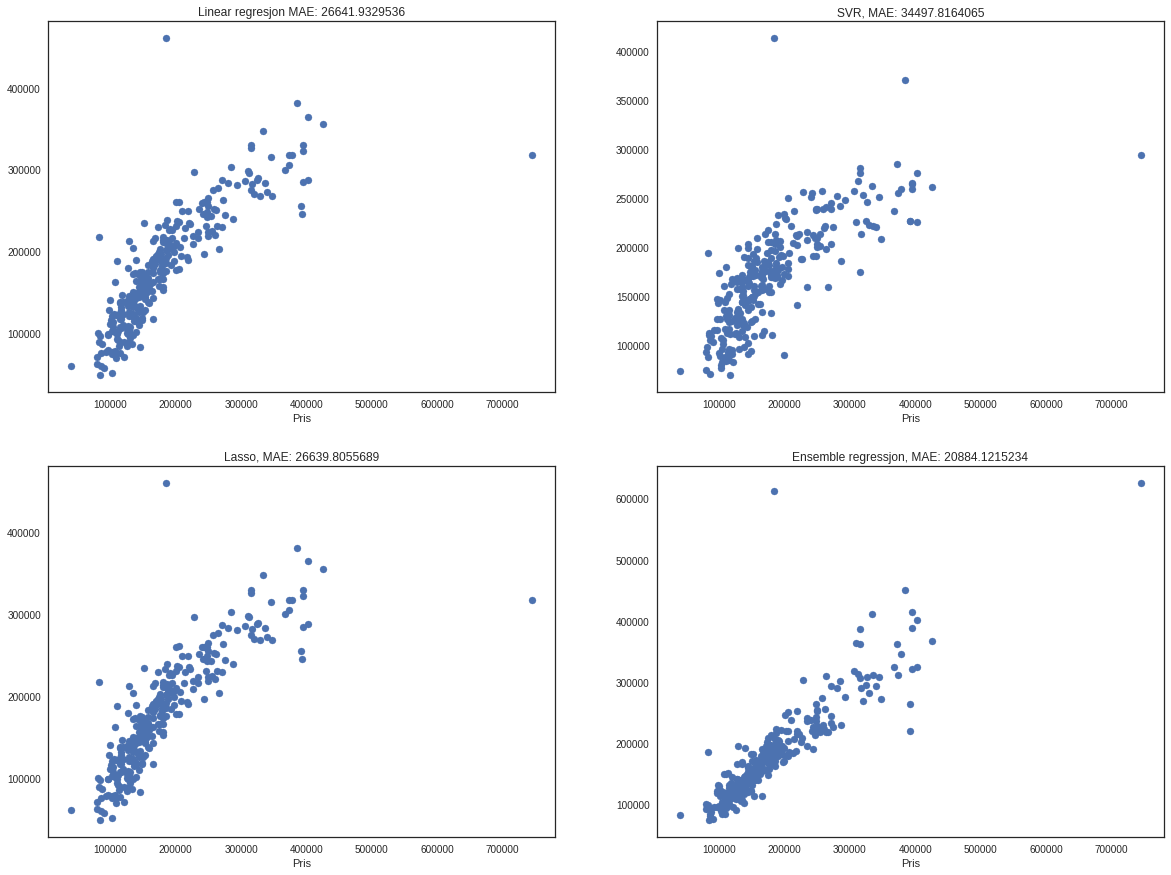

In [70]:
plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
plt.scatter(output_testdata, pris_prediksjone_linr)
plt.xlabel('Predkisjon')
plt.xlabel('Pris')
plt.title('Linear regresjon, MAE: {}'.format(MAE_lin))

plt.subplot(2,2,2)
plt.scatter(output_testdata, pris_prediksjoner_SVR)
plt.xlabel('Predkisjon')
plt.xlabel('Pris')
plt.title('SVR, MAE: {}'.format(MAE_SVR))

plt.subplot(2,2,3)
plt.scatter(output_testdata, pris_prediksjoner_Lasso)
plt.xlabel('Predkisjon')
plt.xlabel('Pris')
plt.title('Lasso, MAE: {}'.format(MAE_Lasso))

plt.subplot(2,2,4)
plt.scatter(output_testdata, pris_prediksjoner_Ensemble)
plt.xlabel('Predkisjon')
plt.xlabel('Pris')
plt.title('Ensemble regressjon, MAE: {}'.format(MAE_Ensamble))


##Hva om vi kjører det fulle datasettet?

In [71]:
#Velg alle kolonner untatt den siste. Denne inneholder Salgsprisen som vi ønsker å predikere
input_data = data_modell.iloc[:,0:-1].copy(deep=True)

#Velg kun siste kolonne. Dette er salgsprisen
output_data = data_modell['SalePrice'].copy(deep=True)

#Dataen deles opp i to sett: treningssett og testsett og lagres i de 4 nye objektene. Test_size bestemmer andelen av dataen som blir brukt til testing av modellen
input_treningsdata, input_testdata, output_treningsdata, output_testdata = train_test_split(input_data, output_data, test_size=0.2, random_state=1)


#Treningsfase
from sklearn.ensemble import GradientBoostingRegressor


#Regressjons-objekt fra scikit-learn
modell = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 3, random_state=1)

#Tilpass regressjonskoeffesienter med treningsdata
modell.fit(input_treningsdata, output_treningsdata)

#Testfase

#Gjør pris-prediksjon på testdataen. 
pris_prediksjoner_Ensemble = modell.predict(input_testdata)

#Beregn feil
MAE_Ensamble = mean_absolute_error(pris_prediksjoner_Ensemble, output_testdata)

#Feilen skrives ut
print("MAE: {}".format(MAE_Ensamble))

MAE: 20221.5722532


In [0]:
plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
plt.scatter(output_testdata, pris_prediksjone_linr)
plt.xlabel('Predkisjon')
plt.xlabel('Pris')
plt.title('Linear regresjon, MAE: {}'.format(MAE_lin))

plt.subplot(2,2,2)
plt.scatter(output_testdata, pris_prediksjoner_SVR)
plt.xlabel('Predkisjon')
plt.xlabel('Pris')
plt.title('SVR, MAE: {}'.format(MAE_SVR))